In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import featuretools as ft
from scipy.stats import t

## I. Read Data & Feature Engineering

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

path = "G:/Football/Kaggle_FIFAplayers/soccer/"  # win

In [3]:
with sqlite3.connect(path+"database.sqlite") as con:
    countries = pd.read_sql_query("SELECT * FROM Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    player = pd.read_sql_query("SELECT * from Player",con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes",con)
    sequence = pd.read_sql_query("SELECT * from sqlite_sequence",con)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes",con)

In [4]:
print(countries.shape)
countries.head()

(11, 2)


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [5]:
print(leagues.shape)
leagues

(11, 3)


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [6]:
print(matches.shape, matches.columns)
matches.head()

(25979, 115) Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [7]:
# check distirbution of year of matches
pd.Series(pd.to_datetime(matches['date']).dt.year.value_counts())

2015    3374
2009    3306
2012    3269
2011    3255
2010    3250
2014    3166
2013    3116
2016    1630
2008    1613
Name: date, dtype: int64

In [8]:
# for exmaple, check matches of EPL
matches[matches["league_id"]==1729].head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,5.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,9.0,11.0,30726.0,30362.0,30620.0,30865.0,32569.0,24148.0,34944.0,30373.0,24154.0,24157.0,30829.0,24224.0,25518.0,24228.0,30929.0,29581.0,38807.0,40565.0,30360.0,33852.0,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...,1.29,5.5,11.00,1.30,4.75,8.25,1.3,4.4,8.50,1.25,4.5,10.00,NaN,NaN,NaN,1.25,4.5,10.00,1.25,5.00,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,5.0,7.0,9.0,1.0,3.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,23686.0,26111.0,38835.0,30986.0,31291.0,31013.0,30935.0,39297.0,26181.0,30960.0,36410.0,36373.0,36832.0,23115.0,37280.0,24728.0,24664.0,31088.0,23257.0,24171.0,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...,1.20,6.5,15.00,1.22,5.50,10.00,1.2,5.2,11.00,1.20,5.0,11.00,NaN,NaN,NaN,1.17,5.5,12.00,1.20,5.50,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,1,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,32562.0,38836.0,24446.0,24408.0,36786.0,38802.0,24655.0,17866.0,30352.0,23927.0,24410.0,30660.0,37442.0,30617.0,24134.0,414792.0,37139.0,30618.0,40701.0,24800.0,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><c

In [9]:
# check how many games having different number of non-missing home players
homeplayers_col = ['home_player_'+str(i+1) for i in range(11)]
matches[homeplayers_col].notnull().apply(sum,axis=1).value_counts()

11    22708
10     1362
0       758
9       322
8       211
7       162
6       131
5       125
4        90
3        70
2        36
1         4
dtype: int64

In [10]:
# similarly, how many games having different number of non-missing away players
awayplayers_col = ['away_player_'+str(i+1) for i in range(11)]
matches[awayplayers_col].notnull().apply(sum,axis=1).value_counts()

11    22652
10     1422
0       758
9       315
8       195
7       170
6       143
5       113
4       108
3        66
2        29
1         8
dtype: int64

In [11]:
# how many games having player id for both home team and away team
players_col = homeplayers_col + awayplayers_col
matches[players_col].notnull().apply(sum,axis=1).value_counts()

22    21374
21     2240
0       758
20      416
19      192
18      112
12      111
15       97
16       92
14       91
17       87
10       86
13       84
11       74
9        60
7        35
8        35
6        19
5         9
4         6
3         1
dtype: int64

In [12]:
# if we require both home team and away team have more than 4 players, number of games will be
((matches[homeplayers_col].notnull().apply(sum,axis=1)>=5)&(matches[awayplayers_col].notnull().apply(sum,axis=1)>=5)).sum()

24874

In [13]:
print(teams.shape)
teams.head()

(299, 5)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [14]:
print(player.shape)
player.head()

(11060, 7)


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [15]:
# unique player ids
player['player_api_id'].unique().shape

(11060,)

In [16]:
print(player_attributes.shape, player_attributes.columns)
player_attributes.head()

(183978, 42) Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [17]:
# sort data frames of matches and player attributes by date, we need to use them later
matches['date'] = pd.to_datetime(matches['date'])
matches.sort_values(by="date", inplace=True)
player_attributes['date'] = pd.to_datetime(player_attributes['date'])
player_attributes.sort_values(by="date", inplace=True)

In [18]:
# add latest ratings of players from df of player attributes to df of matches
# through the following function, which will find the latest rating of players right before matches start
def GetLatestPlayer(df, player_col, player_df):
    if np.isfinite(df[player_col]):
        mpdf = player_df[player_df['player_api_id'] == df[player_col]] 
        #print(mpdf)
        datediff = mpdf['date'] - df['date']
        #print(df['date'])
        ratings = []
        latest_pdf = mpdf[datediff < pd.Timedelta(0)].iloc[-1]
        latest_pdf = latest_pdf.fillna(0)
        
        attacking = latest_pdf['crossing'] + latest_pdf['finishing'] + latest_pdf['heading_accuracy'] + \
                    latest_pdf['short_passing'] + latest_pdf['volleys'] 
        ratings.append(attacking)
        skill = latest_pdf['dribbling'] + latest_pdf['curve'] + latest_pdf['free_kick_accuracy'] + \
                latest_pdf['long_passing'] + latest_pdf['ball_control']
        ratings.append(skill)
        movement = latest_pdf['acceleration'] + latest_pdf['sprint_speed'] + latest_pdf['agility'] + \
                   latest_pdf['reactions'] + latest_pdf['balance']
        ratings.append(movement)
        power = latest_pdf['shot_power'] + latest_pdf['jumping'] + latest_pdf['stamina'] + \
                latest_pdf['strength'] + latest_pdf['long_shots']
        ratings.append(power)
        mentality = latest_pdf['aggression'] + latest_pdf['interceptions'] + latest_pdf['positioning'] + \
                    latest_pdf['vision'] + latest_pdf['penalties']
        ratings.append(mentality)
        defending = latest_pdf['marking'] + latest_pdf['standing_tackle'] + latest_pdf['sliding_tackle']
        ratings.append(defending)
        goalkeeping = latest_pdf['gk_diving'] + latest_pdf['gk_handling'] + latest_pdf['gk_kicking'] + \
                      latest_pdf['gk_positioning'] + latest_pdf['gk_reflexes']
        ratings.append(goalkeeping)
        
        return ratings 
    else:
        return [np.nan] * 7     

In [19]:
# apply the above function on df of matches to add latest ratings of players for both home team and away team
import time
start = time.time()
for k in range(11):
    print(k, 'home_player_' + str(k+1))
    hpratings = matches.apply(GetLatestPlayer, axis=1, player_col='home_player_' + str(k+1), player_df=player_attributes)
    matches['homeplayer'+str(k+1)+'attacking'],matches['homeplayer'+str(k+1)+'skill'], \
    matches['homeplayer'+str(k+1)+'movement'],matches['homeplayer'+str(k+1)+'power'], \
    matches['homeplayer'+str(k+1)+'mentality'],matches['homeplayer'+str(k+1)+'defending'], \
    matches['homeplayer'+str(k+1)+'goalkeeping'] = zip(*hpratings)
    
    print('away_player_' + str(k+1))
    apratings = matches.apply(GetLatestPlayer, axis=1, player_col='away_player_' + str(k+1), player_df=player_attributes)
    matches['awayplayer'+str(k+1)+'attacking'],matches['awayplayer'+str(k+1)+'skill'], \
    matches['awayplayer'+str(k+1)+'movement'],matches['awayplayer'+str(k+1)+'power'], \
    matches['awayplayer'+str(k+1)+'mentality'],matches['awayplayer'+str(k+1)+'defending'], \
    matches['awayplayer'+str(k+1)+'goalkeeping'] = zip(*apratings)
    
endt = time.time()
print(time.strftime("%H:%M:%S", time.gmtime(endt-start)))

0 home_player_1
away_player_1
1 home_player_2
away_player_2
2 home_player_3
away_player_3
3 home_player_4
away_player_4
4 home_player_5
away_player_5
5 home_player_6
away_player_6
6 home_player_7
away_player_7
7 home_player_8
away_player_8
8 home_player_9
away_player_9
9 home_player_10
away_player_10
10 home_player_11
away_player_11
00:26:24


In [20]:
# randomly check merged results
matches.iloc[:,].sample(20)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,...,awayplayer4defending,awayplayer4goalkeeping,homeplayer5attacking,homeplayer5skill,homeplayer5movement,homeplayer5power,homeplayer5mentality,homeplayer5defending,homeplayer5goalkeeping,awayplayer5attacking,awayplayer5skill,awayplayer5movement,awayplayer5power,awayplayer5mentality,awayplayer5defending,awayplayer5goalkeeping,homeplayer6attacking,homeplayer6skill,homeplayer6movement,homeplayer6power,homeplayer6mentality,homeplayer6defending,homeplayer6goalkeeping,awayplayer6attacking,awayplayer6skill,awayplayer6movement,awayplayer6power,awayplayer6mentality,awayplayer6defending,awayplayer6goalkeeping,homeplayer7attacking,homeplayer7skill,homeplayer7movement,homeplayer7power,homeplayer7mentality,homeplayer7defending,homeplayer7goalkeeping,awayplayer7attacking,awayplayer7skill,awayplayer7movement,awayplayer7power,awayplayer7mentality,awayplayer7defending,awayplayer7goalkeeping,homeplayer8attacking,homeplayer8skill,homeplayer8movement,homeplayer8power,homeplayer8mentality,homeplayer8defending,homeplayer8goalkeeping,awayplayer8attacking,awayplayer8skill,awayplayer8movement,awayplayer8power,awayplayer8mentality,awayplayer8defending,awayplayer8goalkeeping,homeplayer9attacking,homeplayer9skill,homeplayer9movement,homeplayer9power,homeplayer9mentality,homeplayer9defending,homeplayer9goalkeeping,awayplayer9attacking,awayplayer9skill,awayplayer9movement,awayplayer9power,awayplayer9mentality,awayplayer9defending,awayplayer9goalkeeping,homeplayer10attacking,homeplayer10skill,homeplayer10movement,homeplayer10power,homeplayer10mentality,homeplayer10defending,homeplayer10goalkeeping,awayplayer10attacking,awayplayer10skill,awayplayer10movement,awayplayer10power,awayplayer10mentality,awayplayer10defending,awayplayer10goalkeeping,homeplayer11attacking,homeplayer11skill,homeplayer11movement,homeplayer11power,homeplayer11mentality,homeplayer11defending,homeplayer11goalkeeping,awayplayer11attacking,awayplayer11skill,awayplayer11movement,awayplayer11power,awayplayer11mentality,awayplayer11defending,awayplayer11goalkeeping
19679,19680,17642,17642,2015/2016,8,2015-10-25,2015876,8348,10238,0,2,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,380949.0,186677.0,245423.0,71352.0,29580.0,112397.0,524434.0,149949.0,229803.0,211118.0,361321.0,96836.0,361379.0,489013.0,45280.0,193805.0,98361.0,45249.0,362661.0,522765.0,193322.0,163839.0,None,None,None,None,None,None,None,None,2.30,3.20,3.20,2.35,3.10,3.00,2.30,3.1,2.90,2.30,3.00,3.20,2.42,3.19,3.34,...,216.0,56.0,292.0,314.0,320.0,343.0,307.0,215.0,52.0,240.0,220.0,297.0,311.0,259.0,206.0,63.0,322.0,352.0,319.0,374.0,344.0,200.0,52.0,271.0,304.0,333.0,359.0,308.0,207.0,58.0,280

In [21]:
# check names of new created columns
for k in range(117, 131, 1):
    print(k, (k-117)%7, matches.columns[k], matches.columns[k][:4] + matches.columns[k][11:])

117 0 homeplayer1movement homemovement
118 1 homeplayer1power homepower
119 2 homeplayer1mentality homementality
120 3 homeplayer1defending homedefending
121 4 homeplayer1goalkeeping homegoalkeeping
122 5 awayplayer1attacking awayattacking
123 6 awayplayer1skill awayskill
124 0 awayplayer1movement awaymovement
125 1 awayplayer1power awaypower
126 2 awayplayer1mentality awaymentality
127 3 awayplayer1defending awaydefending
128 4 awayplayer1goalkeeping awaygoalkeeping
129 5 homeplayer2attacking homeattacking
130 6 homeplayer2skill homeskill


In [22]:
# Create features of 7 dimensional rating for both home team and away team
# Top 4/5/5/5/5/4/1 players' attacking/skill/movement/power/mentality/defending/goalkeeping ratings of a team are 
# chosen to form the team's ratings of 7 dimensions. 
# The intuition is that there are 1 goalkeeper, normally 4 attacking/defending players in one team. 
# These numbers can be changed, for example, can be fixed through the cross validation
def SumTopX(df, X):
    sort_row = np.sort(df.values)[::-1]
    newrow = np.roll(sort_row, -np.count_nonzero(np.isnan(sort_row)))
    topXsum = newrow[:X].sum()
    return topXsum

for k in range(117, 131, 1):
    print(matches.columns[k])
    teamfeature = matches.columns[k][:4] + matches.columns[k][11:]
    print("feature name is {0}".format(teamfeature))
    if ((k-117)%7 == 0) | ((k-117)%7 == 5):
        matches[teamfeature] = matches.iloc[:,range(k,271,14)].apply(SumTopX, axis=1, X=4)
    elif (k-117)%7 == 6:
        matches[teamfeature] = matches.iloc[:,range(k,271,14)].apply(SumTopX, axis=1, X=1)    
    else:
        matches[teamfeature] = matches.iloc[:,range(k,271,14)].apply(SumTopX, axis=1, X=5)
        

homeplayer1movement
feature name is homemovement
homeplayer1power
feature name is homepower
homeplayer1mentality
feature name is homementality
homeplayer1defending
feature name is homedefending
homeplayer1goalkeeping
feature name is homegoalkeeping
awayplayer1attacking
feature name is awayattacking
awayplayer1skill
feature name is awayskill
awayplayer1movement
feature name is awaymovement
awayplayer1power
feature name is awaypower
awayplayer1mentality
feature name is awaymentality
awayplayer1defending
feature name is awaydefending
awayplayer1goalkeeping
feature name is awaygoalkeeping
homeplayer2attacking
feature name is homeattacking
homeplayer2skill
feature name is homeskill


In [23]:
# betting odds
matches.columns[85:120]

Index(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'homeplayer1attacking', 'homeplayer1skill',
       'homeplayer1movement', 'homeplayer1power', 'homeplayer1mentality'],
      dtype='object')

In [24]:
# add additional features: performance difference of last X matches of teams (X=10 here)

# define a function to find the mean of performance difference of last X matches of home/away teams
def GetDiffTeam(df, team, mdf, X=10):
    if team == "home":
        teamdf = mdf[mdf['home_team_api_id']==df['home_team_api_id']]
        teamlastX = teamdf[teamdf['date'] < df['date']].iloc[-X:]
        #print(teamlastX.shape)

        diffs = []
        diffs.append( (teamlastX['home_team_goal'] - teamlastX['away_team_goal']).mean() )
        diffs.append( (teamlastX['homeattacking'] - teamlastX['awayattacking']).mean() )
        diffs.append( (teamlastX['homeskill'] - teamlastX['awayskill']).mean() )
        diffs.append( (teamlastX['homemovement'] - teamlastX['awaymovement']).mean() )
        diffs.append( (teamlastX['homepower'] - teamlastX['awaypower']).mean() )
        diffs.append( (teamlastX['homementality'] - teamlastX['awaymentality']).mean() )
        diffs.append( (teamlastX['homedefending'] - teamlastX['awaydefending']).mean() )
        diffs.append( (teamlastX['homegoalkeeping'] - teamlastX['awaygoalkeeping']).mean() )
       
        return diffs
    
    elif team == "away":
        teamdf = mdf[mdf['away_team_api_id']==df['away_team_api_id']]
        teamlastX = teamdf[teamdf['date'] < df['date']].iloc[-X:]
        diffs = []
        diffs.append( (teamlastX['away_team_goal'] - teamlastX['home_team_goal']).mean() )
        diffs.append( (teamlastX['awayattacking'] - teamlastX['homeattacking']).mean() )
        diffs.append( (teamlastX['awayskill'] - teamlastX['homeskill']).mean() )
        diffs.append( (teamlastX['awaymovement'] - teamlastX['homemovement']).mean() )
        diffs.append( (teamlastX['awaypower'] - teamlastX['homepower']).mean() )
        diffs.append( (teamlastX['awaymentality'] - teamlastX['homementality']).mean() )
        diffs.append( (teamlastX['awaydefending'] - teamlastX['homedefending']).mean() )
        diffs.append( (teamlastX['awaygoalkeeping'] - teamlastX['homegoalkeeping']).mean() )
       
        return diffs

print("home difference...")
homediffs = matches.apply(GetDiffTeam, axis=1, team="home", mdf=matches)
hora = "home_diff_"
matches[hora+'goal'],matches[hora+'attacking'],matches[hora+'skill'],matches[hora+'movement'],matches[hora+'power'], \
matches[hora+'mentality'],matches[hora+'defending'], matches[hora+'goalkeeping'] = zip(*homediffs)

print("away difference...")
awaydiffs = matches.apply(GetDiffTeam, axis=1, team="away", mdf=matches)
hora = "away_diff_"
matches[hora+'goal'],matches[hora+'attacking'],matches[hora+'skill'],matches[hora+'movement'],matches[hora+'power'], \
matches[hora+'mentality'],matches[hora+'defending'], matches[hora+'goalkeeping'] = zip(*awaydiffs)

home difference...
away difference...


In [25]:
# we can save matches with features for further use
print(matches.columns, matches.shape)
#matches.to_csv("matches_features.csv")

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'home_diff_defending', 'home_diff_goalkeeping', 'away_diff_goal',
       'away_diff_attacking', 'away_diff_skill', 'away_diff_movement',
       'away_diff_power', 'away_diff_mentality', 'away_diff_defending',
       'away_diff_goalkeeping'],
      dtype='object', length=299) (25979, 299)


## II. Apply ML models

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, brier_score_loss, f1_score
from sklearn.model_selection import train_test_split

pipeline_preprocessing = [("imputer", SimpleImputer()),
                         ("scaler", RobustScaler(with_centering=True))]

In [30]:
# Create labels for 3 outcomes of matches (0-home win, 1-draw, 2-away win)
y_labels = np.repeat(0, matches.shape[0])
y_labels[matches['home_team_goal'] == matches['away_team_goal']] = 1
y_labels[matches['home_team_goal'] < matches['away_team_goal']] = 2
y_labels

array([2, 0, 2, ..., 1, 2, 0])

In [31]:
# Split data of matches into training/test set by the ratio of 75%/25%

print(matches.shape, y_labels.shape)
print(matches.columns[-30:])

X_train, X_test, y_train, y_test = train_test_split(matches.iloc[:,-30:], y_labels, test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(25979, 299) (25979,)
Index(['homemovement', 'homepower', 'homementality', 'homedefending',
       'homegoalkeeping', 'awayattacking', 'awayskill', 'awaymovement',
       'awaypower', 'awaymentality', 'awaydefending', 'awaygoalkeeping',
       'homeattacking', 'homeskill', 'home_diff_goal', 'home_diff_attacking',
       'home_diff_skill', 'home_diff_movement', 'home_diff_power',
       'home_diff_mentality', 'home_diff_defending', 'home_diff_goalkeeping',
       'away_diff_goal', 'away_diff_attacking', 'away_diff_skill',
       'away_diff_movement', 'away_diff_power', 'away_diff_mentality',
       'away_diff_defending', 'away_diff_goalkeeping'],
      dtype='object')
(19484, 30) (6495, 30) (19484,) (6495,)


In [32]:
# take PSodds of test set as the reference (the goal to beat bookmakers)
testmatches = matches.loc[X_test.index]
result_mat = np.c_[y_test==0, y_test==1, y_test==2]

testprobsum = (1/testmatches[['PSH','PSD','PSA']]).sum(axis=1)

# normalize to get PS odds implied probabilities
PSprob = np.c_[1/testmatches['PSH']/testprobsum, 1/testmatches['PSD']/testprobsum, 1/testmatches['PSA']/testprobsum]
print(PSprob)

# find indices of matches which have non-missing PS odds to compare with our predictions on these games
PSnonna = np.isfinite(PSprob).sum(axis=1)==3
print("Number of games in the test set which have non-missing PS odds: {0}".format(PSnonna.sum()))

print("Accuracy:", (PSprob.argmax(axis=1)[PSnonna] == y_test[PSnonna]).mean() )  # accuracy

print("MSE:", ((PSprob[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(PSprob[PSnonna]) * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(PSprob[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt( ((PSprob[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean() )

print("f1 socre:", f1_score(y_test[PSnonna], PSprob.argmax(axis=1)[PSnonna], average=None) )

[[0.46225719 0.29505778 0.24268503]
 [0.52464838 0.25015451 0.2251971 ]
 [0.71273186 0.19701531 0.09025282]
 ...
 [       nan        nan        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]]
Number of games in the test set which have non-missing PS odds: 5698
Accuracy: 0.5257985257985258
MSE: 0.19315515971206001  baseline: 0.22222222222222232
log.likelihood: -0.3243834245068781  baseline: -0.3662040962227032
l1 norm: 0.3870875170797991  baseline: 0.4444444444444444
l2 norm: 0.7222949854836146  baseline: 0.816496580927726
f1 socre: [0.65275027 0.         0.50324101]


## a. Random forest

In [33]:
# apply the random forest with labels of 3 outcomes
rf_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
pipeline = Pipeline(pipeline_preprocessing + [('rf_clf', rf_clf)])

pipeline.fit(X_train, y_train)
test_predictprob = pipeline.predict_proba(X_test)
test_predictprob

array([[0.5 , 0.36, 0.14],
       [0.42, 0.28, 0.3 ],
       [0.78, 0.14, 0.08],
       ...,
       [0.34, 0.26, 0.4 ],
       [0.26, 0.22, 0.52],
       [0.54, 0.24, 0.22]])

In [34]:
# different metrics of Random forest's prediction with labels of 3 outcomes
# result matrix
result_mat = np.c_[y_test==0, y_test==1, y_test==2]

print("Accuracy:", pipeline.score(X_test, y_test), (pipeline.predict(X_test)[PSnonna]==y_test[PSnonna]).mean())  # accuracy

print("MSE:", ((test_predictprob[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(test_predictprob)[PSnonna] * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(test_predictprob[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt( ((test_predictprob[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean())

# use the function f1_score in sklearn
print("f1 socre:", f1_score(y_test[PSnonna], pipeline.predict(X_test)[PSnonna], average=None) )

Accuracy: 0.4897613548883757 0.49613899613899615
MSE: 0.20223596419139786  baseline: 0.22222222222222232
log.likelihood: nan  baseline: -0.3662040962227032
l1 norm: 0.3979432521575379  baseline: 0.4444444444444444
l2 norm: 0.7442232661247747  baseline: 0.816496580927726
f1 socre: [0.63270942 0.11196487 0.43390052]


## b. Xgboost

In [35]:
# xgboost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV    #Performing grid search
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

(14613, 30) (4871, 30) (6495, 30) (14613,) (4871,) (6495,)

Model Report
Accuracy (Train) : 0.9818
F1 Score (Train): [0.98274112 0.97968089 0.98210539]
Classification (Train):
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      6798
           1       1.00      0.96      0.98      3727
           2       0.99      0.97      0.98      4088

   micro avg       0.98      0.98      0.98     14613
   macro avg       0.99      0.98      0.98     14613
weighted avg       0.98      0.98      0.98     14613

Accuracy (Test): 0.4714
F1 Score (Test): [0.60475847 0.20786934 0.40761678]
Classification (Test):
               precision    recall  f1-score   support

           0       0.52      0.72      0.60      2895
           1       0.27      0.17      0.21      1660
           2       0.48      0.35      0.41      1940

   micro avg       0.47      0.47      0.47      6495
   macro avg       0.42      0.42      0.41      6495
weighted avg    

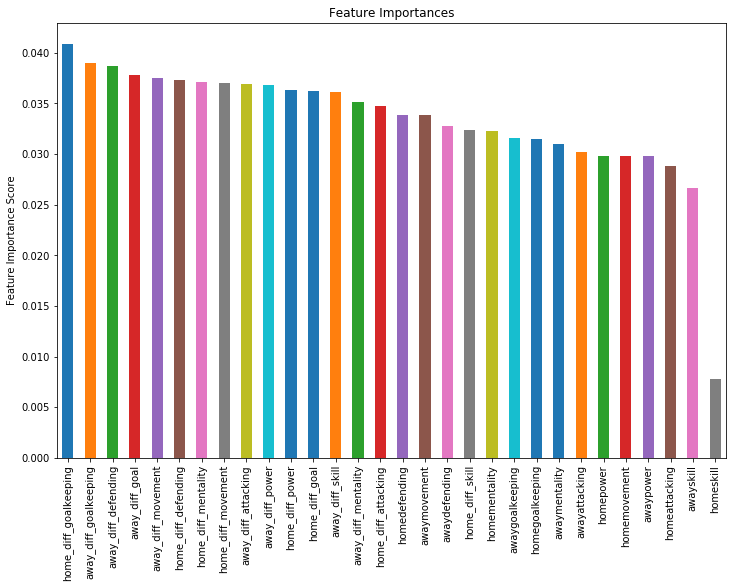

In [36]:
# xgboost with labels of 3 outcomes

# construct the validation set from training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

xgb1 = XGBClassifier(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective='multi:softmax',
         nthread=4,
         scale_pos_weight=1,
         seed=27)

### the function to fit the model

def modelfit(alg, dtrain, train_labels, dtest, test_labels, deval, eval_error, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain, label=train_labels, feature_names=dtrain.columns)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True, show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    # with validation set
    #alg.fit(dtrain, train_labels, eval_set = deval, eval_metric=eval_error, early_stopping_rounds=early_stopping_rounds)
    # without validation set
    alg.fit(dtrain, train_labels, eval_metric=eval_error)

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)
        
    #Predict test set:
    dtest_predictions = alg.predict(dtest)
    dtest_predprob = alg.predict_proba(dtest)

    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(train_labels, dtrain_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(train_labels, dtrain_predprob))  # only binary
    print("F1 Score (Train):", metrics.f1_score(train_labels, dtrain_predictions, average=None))
    print("Classification (Train):\n", metrics.classification_report(train_labels, dtrain_predictions)) 
                                        #,target_names=["home win", "draw", "away win"]))
                    
    print("Accuracy (Test): %.4g" % metrics.accuracy_score(test_labels, dtest_predictions))
    #print("AUC Score (Test): %f" % metrics.roc_auc_score(test_labels, dtest_predprob)) 
    print("F1 Score (Test):", metrics.f1_score(test_labels, dtest_predictions, average=None))
    print("Classification (Test):\n", metrics.classification_report(test_labels, dtest_predictions))
                                        #,target_names=["home win", "draw", "away win"]))
    
    feat_imp = pd.Series(alg.feature_importances_, index=dtrain.columns).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return dtest_predictions, dtest_predprob

# due to the order of time sequence, we can not use k-fold cv here
xgb_predictions, xgb_predictprob = modelfit(xgb1, dtrain=X_train, train_labels=y_train,
                                              dtest=X_test, test_labels=y_test, 
                                              deval=[(X_val, y_val)], eval_error="merror", useTrainCV=False)
print(xgb_predictions)
print(xgb_predictprob)

In [37]:
# different metrics of xgboost with labels of 3 outcomes
result_mat = np.c_[y_test==0, y_test==1, y_test==2]

print("Accuracy:", (xgb_predictions[PSnonna]==y_test[PSnonna]).mean())  # accuracy

print("MSE:", ((xgb_predictprob[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(xgb_predictprob)[PSnonna] * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(xgb_predictprob[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt(((xgb_predictprob[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean())

print("f1 socre:", f1_score(y_test[PSnonna], xgb_predictions[PSnonna], average=None) )

Accuracy: 0.47455247455247457
MSE: 0.21397513  baseline: 0.22222222222222232
log.likelihood: -0.36224562  baseline: -0.3662040962227032
l1 norm: 0.3884109  baseline: 0.4444444444444444
l2 norm: 0.73788637  baseline: 0.816496580927726
f1 socre: [0.61025224 0.19469796 0.41016949]


## c. Logistic regression

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
logr_clf = LogisticRegression(multi_class="auto", solver="newton-cg", n_jobs=-1)
pipeline = Pipeline(pipeline_preprocessing + [('logr_clf', logr_clf)])

pipeline.fit(X_train, y_train)
logr_predictprob = pipeline.predict_proba(X_test)
logr_predictprob

array([[0.43060129, 0.30573826, 0.26366045],
       [0.56231834, 0.282745  , 0.15493666],
       [0.69089406, 0.19229755, 0.11680839],
       ...,
       [0.40052773, 0.23229606, 0.36717621],
       [0.235052  , 0.2442366 , 0.52071141],
       [0.59736357, 0.23429276, 0.16834367]])

In [40]:
# different metrics of logistic regression with labels of 3 outcomes
result_mat = np.c_[y_test==0, y_test==1, y_test==2]
logr_predictions = pipeline.predict(X_test)

print("Accuracy:", (logr_predictions[PSnonna]==y_test[PSnonna]).mean())  # accuracy

print("MSE:", ((logr_predictprob[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(logr_predictprob)[PSnonna] * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(logr_predictprob[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt(((logr_predictprob[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean())

print("f1 socre:", f1_score(y_test[PSnonna], logr_predictions[PSnonna], average=None) )

Accuracy: 0.5094770094770095
MSE: 0.19710740311818573  baseline: 0.22222222222222232
log.likelihood: -0.33043839916481155  baseline: -0.3662040962227032
l1 norm: 0.3992183119639944  baseline: 0.4444444444444444
l2 norm: 0.7424281634763457  baseline: 0.816496580927726
f1 socre: [0.63965568 0.00138889 0.46426352]


## d. Support vector machine

In [41]:
# support vector classification
from sklearn.svm import SVC

In [42]:
# linear kernel
svclf = SVC(kernel="linear", probability=True)  # enable probability estimates and there are different kernels
pipeline = Pipeline(pipeline_preprocessing + [('svclf', svclf)])

pipeline.fit(X_train, y_train)
sv_predictprob = pipeline.predict_proba(X_test)
sv_predictprob

array([[0.46347175, 0.29971199, 0.23681626],
       [0.5320466 , 0.31340656, 0.15454684],
       [0.5836349 , 0.2840584 , 0.1323067 ],
       ...,
       [0.37901342, 0.24223316, 0.37875342],
       [0.26262983, 0.22464358, 0.51272659],
       [0.52558137, 0.30515001, 0.16926862]])

In [43]:
# different metrics of linear svm with labels of 3 outcomes
result_mat = np.c_[y_test==0, y_test==1, y_test==2]
sv_predictions = pipeline.predict(X_test)
print(np.unique(sv_predictions))

print("Accuracy:", (sv_predictions[PSnonna]==y_test[PSnonna]).mean())  # accuracy

print("MSE:", ((sv_predictprob[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(sv_predictprob)[PSnonna] * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(sv_predictprob[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt(((sv_predictprob[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean())

print("f1 socre:", f1_score(y_test[PSnonna], sv_predictions[PSnonna], average=None) )

[0 2]
Accuracy: 0.5131625131625132
MSE: 0.200114723310607  baseline: 0.22222222222222232
log.likelihood: -0.3347115016067005  baseline: -0.3662040962227032
l1 norm: 0.4084104459737848  baseline: 0.4444444444444444
l2 norm: 0.7588944955919021  baseline: 0.816496580927726


C:\Users\Roger\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 socre: [0.64601895 0.         0.44336682]


In [44]:
# rbf kernel
sv_rbf = SVC(kernel="rbf", probability=True)  # enable probability estimates and there are different kernels
pipeline = Pipeline(pipeline_preprocessing + [('sv_rbf', sv_rbf)])

pipeline.fit(X_train, y_train)
svrbf_predictprob = pipeline.predict_proba(X_test)
svrbf_predictprob

C:\Users\Roger\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([[0.54036691, 0.27360174, 0.18603135],
       [0.54954518, 0.27418452, 0.1762703 ],
       [0.56791218, 0.26833925, 0.16374857],
       ...,
       [0.35581044, 0.24011531, 0.40407425],
       [0.20079677, 0.23435591, 0.56484732],
       [0.55542367, 0.27146754, 0.17310879]])

In [45]:
# different metrics of rbf svm with labels of 3 outcomes
result_mat = np.c_[y_test==0, y_test==1, y_test==2]
svrbf_predictions = pipeline.predict(X_test)
print(np.unique(svrbf_predictions))

print("Accuracy:", (svrbf_predictions[PSnonna]==y_test[PSnonna]).mean())  # accuracy

print("MSE:", ((svrbf_predictprob[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(svrbf_predictprob)[PSnonna] * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(svrbf_predictprob[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt(((svrbf_predictprob[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean())

print("f1 socre:", f1_score(y_test[PSnonna], svrbf_predictions[PSnonna], average=None) )

[0 2]
Accuracy: 0.5087750087750088
MSE: 0.20362559349610765  baseline: 0.22222222222222232
log.likelihood: -0.33979430481284495  baseline: -0.3662040962227032
l1 norm: 0.40723371556546484  baseline: 0.4444444444444444
l2 norm: 0.7596684583657317  baseline: 0.816496580927726


C:\Users\Roger\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 socre: [0.64595593 0.         0.406639  ]


## III. Cyclic MM for BT with home effect and draw outcome

In [46]:
## Split into training&test set
## Create labels for 3 outcomes of matches (0-home win, 1-draw, 2-away win)
y_labels = np.repeat(0, matches.shape[0])
y_labels[matches['home_team_goal'] == matches['away_team_goal']] = 1
y_labels[matches['home_team_goal'] < matches['away_team_goal']] = 2
y_labels

X_train, X_test, y_train, y_test = train_test_split(matches, y_labels, test_size=0.25, shuffle=False)
print(X_train.shape, X_test.shape)

(19484, 299) (6495, 299)


In [47]:
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
5,6,8635,229.0,RSC Anderlecht,AND
6,7,9991,674.0,KAA Gent,GEN
7,8,9998,1747.0,RAEC Mons,MON
8,9,7947,NaN,FCV Dender EH,DEN
9,10,9985,232.0,Standard de Liège,STL


In [48]:
# find all teams in the dataset
print("Number of unique teams in teams df:", teams["team_api_id"].unique().shape[0])

# number of unique teams in matches df
mat_teams = np.unique(matches[['home_team_api_id', 'away_team_api_id']].values)
# discard nan team id
mat_teams = mat_teams[np.isfinite(mat_teams)]
print("Number of unique teams in matches df:", mat_teams.shape[0])
print("Number of unique home teams in matches df:", np.unique(matches['home_team_api_id'].values).shape[0])

# number of unique teams in training df
train_teams = np.unique(X_train[['home_team_api_id', 'away_team_api_id']].values)
print("Number of unique teams in training df:", train_teams.shape[0])
print("Number of unique home teams in training df:", np.unique(X_train['home_team_api_id'].values).shape[0])

mat_teams

Number of unique teams in teams df: 299
Number of unique teams in matches df: 299
Number of unique home teams in matches df: 299
Number of unique teams in training df: 281
Number of unique home teams in training df: 281


array([  1601,   1773,   1957,   2033,   2182,   2183,   2186,   4049,
         4064,   4087,   4170,   6269,   6351,   6367,   6391,   6403,
         6413,   6421,   6433,   6493,   6547,   6601,   6631,   7730,
         7788,   7794,   7819,   7841,   7842,   7844,   7869,   7878,
         7896,   7943,   7947,   7955,   7992,   8019,   8020,   8021,
         8023,   8024,   8025,   8027,   8028,   8030,   8031,   8033,
         8066,   8121,   8152,   8165,   8177,   8178,   8191,   8194,
         8197,   8203,   8226,   8234,   8242,   8244,   8245,   8262,
         8277,   8284,   8295,   8302,   8305,   8306,   8315,   8322,
         8342,   8344,   8348,   8350,   8357,   8358,   8370,   8371,
         8372,   8388,   8394,   8398,   8406,   8426,   8429,   8455,
         8456,   8457,   8460,   8462,   8464,   8466,   8467,   8472,
         8475,   8479,   8481,   8483,   8485,   8521,   8524,   8525,
         8526,   8528,   8529,   8530,   8533,   8534,   8535,   8537,
      

In [49]:
# compare team_api_id with the list of teams
teams['team_api_id'].isin(mat_teams).sum()

299

In [50]:
# For 281 teams in the training set, let's start the implementation of cyclic MM algorithm
# a. create 3 matirces (a_ij, t_ij, b_ij) 
# a_ij: number of games i beats j at i's home
# t_ij: number of games i ties j at i's home
# b_ij: number of games i loses to j at i's home

# train_teams[18]: 6547 never wins/ties in the dataset, we discard it to ensure MM goes well
# so now we have 280 teams

train_teams = np.unique(X_train[['home_team_api_id', 'away_team_api_id']].values)
train_teams = np.delete(train_teams, 18)
print("New number of unique teams in training set:", train_teams.shape[0])

Amat = np.zeros((train_teams.shape[0], train_teams.shape[0]))
Tmat = np.zeros((train_teams.shape[0], train_teams.shape[0]))
Bmat = np.zeros((train_teams.shape[0], train_teams.shape[0]))

def update_counts(df, team_array, countwhich):
    at = df['away_team_api_id']
    #print(at)
    at_pos = np.where(team_array==at)
    #print(at_pos)
    ht_update = np.zeros(team_array.size)
    
    if (countwhich == 'win') & (df['home_team_goal'] > df['away_team_goal']):
       ht_update[at_pos] += 1
    if (countwhich == 'draw') & (df['home_team_goal'] == df['away_team_goal']):
       ht_update[at_pos] += 1    
    if (countwhich == 'lose') & (df['home_team_goal'] < df['away_team_goal']):
       ht_update[at_pos] += 1    
    return ht_update

for (k,hteam) in enumerate(train_teams):
    # all games that hteam have at its home court
    games_ht = X_train[X_train['home_team_api_id']==hteam]
    if k%100 == 0:
        print(k, hteam)
    if not games_ht.empty:
        Amat[k, ] = games_ht.apply(update_counts, axis=1, team_array=train_teams, countwhich='win').sum()
        Tmat[k, ] = games_ht.apply(update_counts, axis=1, team_array=train_teams, countwhich='draw').sum()
        Bmat[k, ] = games_ht.apply(update_counts, axis=1, team_array=train_teams, countwhich='lose').sum() 
    

New number of unique teams in training set: 280
0 1601
100 8540
200 9873


In [51]:
# check sum of 3 cases for teams in the training set
print((Amat+Tmat+Bmat).sum(axis=1))

print((Amat+Tmat).sum(axis=1))

[ 91.  30.  93.  75.  93.  75.  77.  17.  15.  58.  19.  18.  15.  90.
  35.  30.  18.  54.  17.   1.  53.  18.  39.  58.  90.  30.  90.  57.
  19.  17.  63.  15.   3.  78.  75.  32.  60.  92.  18.  62.  92.  45.
  47.  96.  17.  85.  68. 102.  19.  17.   1.  78. 102.  30.  30.  77.
 103.  21.  17. 114. 114. 114.  45.  78.  19.  15.  34.  17.  85.  57.
 114.  19.  76.  17.  51.  20.  59. 114. 114.  19.  38. 102.  38.  95.
 114.  20.  19.  95.  19. 115.  57.  94.  69.  51.  95. 113. 113. 114.
 112.  38.  95. 113.  76.  19.   1.  75. 114.  76.  76. 113.  77.  78.
   5.  57.  76.  76. 114.  39. 114. 103.  38. 116. 113.  57.  76. 103.
  34. 114. 114.  78. 113. 115. 103.  40. 114.  96.  76.  38.  96.  95.
  57. 114.  93. 102.  38. 113. 115.  19.  76. 102. 102.  68.  19.  20.
 115. 103.  46.  15.  90.  45.  90.  91.  17.  35.  76. 102. 102. 102.
 103.  19. 115. 102.  57.  45.  45.  85. 102.  20. 115.  19. 114.  77.
  39. 115.  19.  39.  68. 115.  57. 115. 114.  38. 112.  19. 114. 114.
  76. 

In [52]:
# b. cyclic MM

# initialize the rating vector, parameter of home effect and draw threshold
home_para = 0.5
draw_thresh = 1.5
ratings = np.ones(train_teams.shape[0])

old_homepara = home_para
old_drawthresh = draw_thresh
old_rating = ratings
niter = 200

for k in range(niter):
    # calculate the new rating
    r_num = (Amat + Bmat.T + Tmat + Tmat.T).sum(axis=1)
    #print(r_num)
    # rating matrix (same columns)
    rating_mat = np.tile(old_rating.reshape(-1,1), (1,old_rating.size))
    
    r_den = (old_homepara*(Amat + Tmat)/(old_homepara*rating_mat + old_drawthresh*rating_mat.T) + 
             (Bmat.T + Tmat.T)/(old_homepara*old_drawthresh*rating_mat.T + rating_mat) + 
             old_homepara*old_drawthresh*(Bmat + Tmat)/(old_homepara*old_drawthresh*rating_mat + rating_mat.T) +
             old_drawthresh*(Amat.T+Tmat.T)/(old_homepara*rating_mat.T + old_drawthresh*rating_mat) ).sum(axis=1)
    #print(r_den)
    new_rating = r_num/r_den
    
    # normalize (sum equals to 1, to identify)
    new_rating = new_rating/new_rating.sum()
    
    # calculate the new draw threshold
    newrating_mat = np.tile(new_rating.reshape(-1,1), (1,old_rating.size))
    
    Ck = ((Amat+Tmat)*newrating_mat.T/(old_homepara*newrating_mat + old_drawthresh*newrating_mat.T) + 
          (Bmat+Tmat)*old_homepara*newrating_mat/(old_homepara*old_drawthresh*newrating_mat + newrating_mat.T)).sum()
    #print(Ck)
    T = Tmat.sum()
    new_drawthresh = (T+np.sqrt(T**2+Ck**2))/Ck
    
    # calculate the new home parameter
    hp_num = (Amat+Tmat).sum()
    hp_den = ((Amat+Tmat)*newrating_mat/(old_homepara*newrating_mat + new_drawthresh*newrating_mat.T) + 
              (Bmat+Tmat)*new_drawthresh*newrating_mat/(old_homepara*new_drawthresh*newrating_mat + newrating_mat.T)).sum()
    new_homepara = hp_num/hp_den
    
    # judge whether to stop the iteration
    rating_diff = np.sqrt( ((new_rating-old_rating)**2).sum() )
    cond1 = rating_diff < 10**(-5)
    cond2 = np.abs(new_homepara - old_homepara) < 10**(-5)
    cond3 = np.abs(new_drawthresh - old_drawthresh) < 10**(-5)
    if cond1 & cond2 & cond3:
        print( "{0}-th iteration, l2 norm difference of ratings is {1}, home parameter is {2}, draw threshold is {3}".format(
                k, rating_diff, new_homepara, new_drawthresh) )
        print(new_rating)
        break
    else:
        old_rating = new_rating
        old_drawthresh = new_drawthresh
        old_homepara = new_homepara
    if k % 10 == 0: 
        print( "{0}-th iteration, l2 norm difference of ratings is {1}, home parameter is {2}, draw threshold is {3}".format(
            k, rating_diff, new_homepara, new_drawthresh) )

0-th iteration, l2 norm difference of ratings is 16.67344617008677, home parameter is 0.877287778814144, draw threshold is 1.6356584649344132
10-th iteration, l2 norm difference of ratings is 0.0008495588605488514, home parameter is 1.545774282748819, draw threshold is 1.8483330453402804
20-th iteration, l2 norm difference of ratings is 8.577584850710266e-05, home parameter is 1.5590554717317728, draw threshold is 1.8539799917278228
30-th iteration, l2 norm difference of ratings is 9.01089001978566e-06, home parameter is 1.5595805204249558, draw threshold is 1.8542851269671292
31-th iteration, l2 norm difference of ratings is 7.204895781764657e-06, home parameter is 1.5595890919580138, draw threshold is 1.8542907316128485
[0.0038437  0.00247622 0.00348263 0.00213006 0.00724207 0.00396824
 0.00208729 0.0012403  0.00134295 0.00269502 0.00153521 0.00143448
 0.00137002 0.00263689 0.00293219 0.00199947 0.00223433 0.00171518
 0.00141549 0.00340585 0.00145069 0.00294647 0.00284641 0.00236891


In [53]:
# Use BT ratings to predict the test set

# create a dict of ratings
traint_dict = dict(zip(train_teams, new_rating))
#print(traint_dict)

# choose one test match
testmatch = X_test.iloc[[100]]
print('home team:{0}, away team:{1}'.format(testmatch['home_team_api_id'].iloc[0], testmatch['away_team_api_id'].iloc[0]))

htrating = traint_dict[testmatch['home_team_api_id'].iloc[0]]
atrating = traint_dict[testmatch['away_team_api_id'].iloc[0]]

probhw = new_homepara*htrating/(new_homepara*htrating + new_drawthresh*atrating)
probd = atrating/(new_homepara*new_drawthresh*htrating + atrating)
probaw = 1-probhw-probd
print(htrating, atrating, probhw, probd, probaw)

print([probhw, probd, probaw]*testmatch[['PSH','PSD','PSA']].values)
testmatch

home team:6433, away team:8525
0.002234332188970792 0.0010207210621525186 0.6480213678546498 0.13641887374090966 0.21555975840444053
[[1.49692936 0.48974376 0.68763563]]


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,...,homeplayer7attacking,homeplayer7skill,homeplayer7movement,homeplayer7power,homeplayer7mentality,homeplayer7defending,homeplayer7goalkeeping,awayplayer7attacking,awayplayer7skill,awayplayer7movement,awayplayer7power,awayplayer7mentality,awayplayer7defending,awayplayer7goalkeeping,homeplayer8attacking,homeplayer8skill,homeplayer8movement,homeplayer8power,homeplayer8mentality,homeplayer8defending,homeplayer8goalkeeping,awayplayer8attacking,awayplayer8skill,awayplayer8movement,awayplayer8power,awayplayer8mentality,awayplayer8defending,awayplayer8goalkeeping,homeplayer9attacking,homeplayer9skill,homeplayer9movement,homeplayer9power,homeplayer9mentality,homeplayer9defending,homeplayer9goalkeeping,awayplayer9attacking,awayplayer9skill,awayplayer9movement,awayplayer9power,awayplayer9mentality,awayplayer9defending,awayplayer9goalkeeping,homeplayer10attacking,homeplayer10skill,homeplayer10movement,homeplayer10power,homeplayer10mentality,homeplayer10defending,homeplayer10goalkeeping,awayplayer10attacking,awayplayer10skill,awayplayer10movement,awayplayer10power,awayplayer10mentality,awayplayer10defending,awayplayer10goalkeeping,homeplayer11attacking,homeplayer11skill,homeplayer11movement,homeplayer11power,homeplayer11mentality,homeplayer11defending,homeplayer11goalkeeping,awayplayer11attacking,awayplayer11skill,awayplayer11movement,awayplayer11power,awayplayer11mentality,awayplayer11defending,awayplayer11goalkeeping,homemovement,homepower,homementality,homedefending,homegoalkeeping,awayattacking,awayskill,awaymovement,awaypower,awaymentality,awaydefending,awaygoalkeeping,homeattacking,homeskill,home_diff_goal,home_diff_attacking,home_diff_skill,home_diff_movement,home_diff_power,home_diff_mentality,home_diff_defending,home_diff_goalkeeping,away_diff_goal,away_diff_attacking,away_diff_skill,away_diff_movement,away_diff_power,away_diff_mentality,away_diff_defending,away_diff_goalkeeping
15361,15362,13274,13274,2014/2015,4,2014-08-29,1712421,6433,8525,1,0,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,3.0,5.0,7.0,1.0,2.0,4.0,6.0,8.0,3.0,5.0,7.0,3.0,5.0,7.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,10.0,10.0,10.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,10.0,10.0,10.0,231674.0,422117.0,150589.0,21765.0,422273.0,243473.0,110135.0,352023.0,115723.0,17259.0,262753.0,156546.0,27276.0,243481.0,45837.0,242260.0,145586.0,209371.0,10880.0,178506.0,305831.0,47552.0,None,None,None,None,None,None,None,None,2.25,3.5,3.0,2.15,3.4,2.95,2.1,3.2,3.1,2.1,3.5,3.2,2.31,3.59,3.19,...,294.0,319.0,330.0,333.0,291.0,174.0,57.0,282.0,337.0,323.0,309.0,268.0,69.0,49.0,294.0,344.0,365.0,340.0,305.0,168.0,56.0,295.0,292.0,324.0,301.0,326.0,177.0,56.0,274.0,313.0,356.0,307.0,245.0,72.0,57.0,289.0,280.0,389.0,315.0,234.0,71.0,48.0,316.0,309.0,260.0,357.0,278.0,104.0,51.0,282.0,295.0,402.0,361.0,246

In [54]:
# obatin preidcted probs on the whole test set
BTpred = []
for i,m in X_test.iterrows():
    if m['home_team_api_id'] in traint_dict.keys():
        htrating = traint_dict[m['home_team_api_id']]
    else:
        htrating = new_rating.mean()
    if m['away_team_api_id'] in traint_dict.keys():
        atrating = traint_dict[m['away_team_api_id']]
    else:
        atrating = new_rating.mean()
        
    probhw = new_homepara*htrating/(new_homepara*htrating + new_drawthresh*atrating)
    probd = atrating/(new_homepara*new_drawthresh*htrating + atrating)
    probaw = 1-probhw-probd

    BTpred.append([probhw, probd, probaw])
    
BTpred_arr = np.array(BTpred)

In [55]:
print(BTpred_arr)

BTpreds = np.argmax(BTpred_arr, axis=1)
print(pd.Series(BTpreds).value_counts())
BTpreds

[[0.50608999 0.2210831  0.27282691]
 [0.74781111 0.08931915 0.16286974]
 [0.58119255 0.17326309 0.24554437]
 ...
 [0.45678428 0.25698295 0.28623277]
 [0.36127309 0.33958106 0.29914585]
 [0.82171978 0.059354   0.11892622]]
0    4787
1    1708
dtype: int64


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
# different metrics of BT with labels of 3 outcomes
result_mat = np.c_[y_test==0, y_test==1, y_test==2]

print("Accuracy:", (BTpreds[PSnonna]==y_test[PSnonna]).mean())  # accuracy

print("MSE:", ((BTpred_arr[PSnonna] - result_mat[PSnonna])**2).mean(), " baseline:", ((1/3 - result_mat)**2).mean())

print("log.likelihood:", (np.log(BTpred_arr)[PSnonna] * result_mat[PSnonna]).mean(), " baseline:", (np.log(1/3) * result_mat).mean())

print("l1 norm:", np.abs(BTpred_arr[PSnonna] - result_mat[PSnonna]).mean(), " baseline:", np.abs(1/3 - result_mat).mean())

print("l2 norm:", np.sqrt(((BTpred_arr[PSnonna] - result_mat[PSnonna])**2).sum(axis=1) ).mean(), " baseline:", np.sqrt( ((1/3 - result_mat)**2).sum(axis=1) ).mean())

print("f1 socre:", f1_score(y_test[PSnonna], BTpreds[PSnonna], average=None) )

Accuracy: 0.4452439452439452
MSE: 0.21441560615334807  baseline: 0.22222222222222232
log.likelihood: -0.3555126919262022  baseline: -0.3662040962227032
l1 norm: 0.4099100451187751  baseline: 0.4444444444444444
l2 norm: 0.7666916283350769  baseline: 0.816496580927726


C:\Users\Roger\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 socre: [0.63617464 0.26770586 0.        ]
